# ***Fake News Detection*** – Exploratory Data Analysis and Feature Engineering

## ***Project Overview***

In an era where misinformation spreads rapidly, we tackled the challenge of distinguishing fake news from credible sources. We laid the groundwork for a fake news detection model by conducting thorough Exploratory Data Analysis (EDA) and Feature Engineering, aiming to refine the raw data and extract key signals—linguistic patterns and structural traits like writing style and clickbait markers—to train a model to spot the difference between real and fabricated articles.

In [16]:
import re
from itertools import product

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [ ]:
import os
import sys
import importlib

sys.path.append(os.path.abspath(os.getcwd()))

import utils.data_preprocess
importlib.reload(utils.data_preprocess)

from utils.data_preprocess import run_pipeline

In [18]:
SEED = 13

## ***Exploratory Data Analysis***

### ***1. Data Loading and Basic Inspection***

We started by loading two CSV files, one with true news, the other with fake news, and examined their contents. We checked for missing values, ensured column consistency, and gathered basic stats like article counts and unique values to get a clear picture of the dataset and flag any immediate issues, such as imbalanced classes.

In [19]:
true_news = pd.read_csv("dataset/true.csv")
fake_news = pd.read_csv("dataset/fake.csv")

true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [20]:
true_news.describe(include="all")

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [21]:
true_news.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

We have 4 features and 21417 records. The news dataframe contains articles `title`, body `text`, category or `subject` and `date` of publication. We have no missing values, but it looks like we might have some duplications. Unique values for `title` and `text` do not match the count.

In [22]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [23]:
fake_news.describe(include="all")

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [24]:
fake_news.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

The structure of **fake news** dataset is the same as the previous one, the total number of articles is quite similar, but we see that there are more `subjects` and it seems that duplicate records might have a bigger weight, reducing the total count of more than 6000.

***Duplicated Titles***

In [25]:
true_title_duplicates = true_news["title"].duplicated().sum()
fake_title_duplicates = fake_news["title"].duplicated().sum()

true_title_duplicates, fake_title_duplicates

(591, 5578)

***Duplicated Texts***

In [26]:
true_text_duplicates = true_news["text"].duplicated().sum()
fake_text_duplicates = fake_news["text"].duplicated().sum()

true_text_duplicates, fake_text_duplicates

(225, 6026)

***Datasets Concatenation***

We add a label in order to be able to distinguish the records and we convert date field from plain text to `datetime` format.

In [27]:
true_news["fake"] = 0
fake_news["fake"] = 1

FAKE_MAP = {0: "True", 1: "Fake"}

true_news["date"] = pd.to_datetime(true_news["date"], errors="coerce")
fake_news["date"] = pd.to_datetime(fake_news["date"], errors="coerce")

news_data = pd.concat([true_news, fake_news], ignore_index=True)

***Target Feature Distribution***

Let's display the distribution of `True` and `Fake` news.

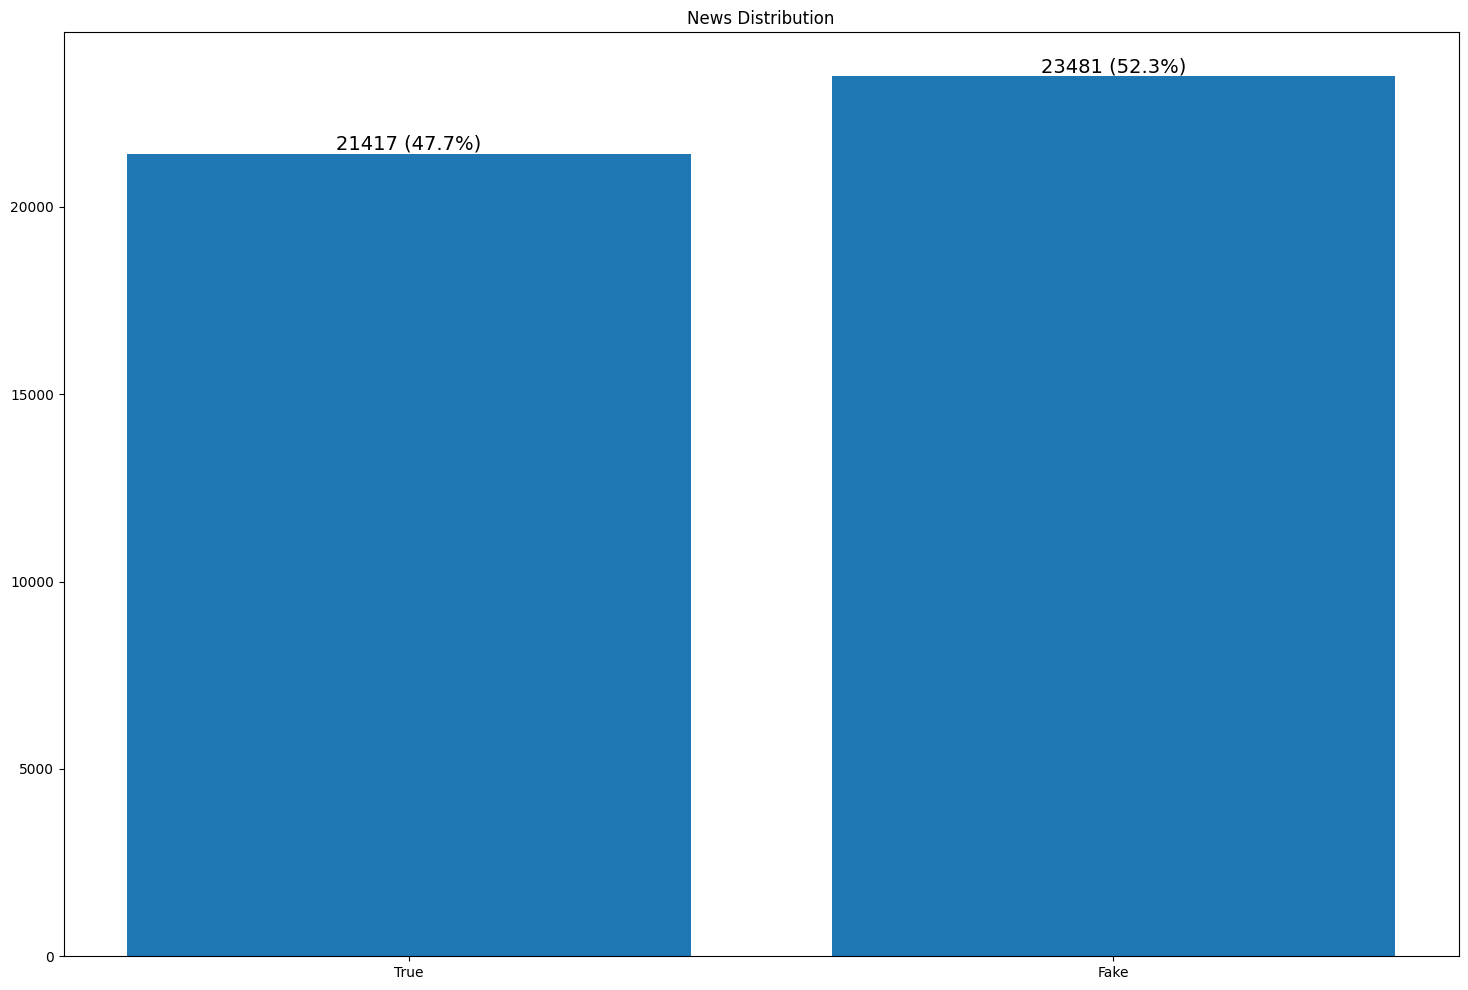

In [13]:
plt.figure(figsize=(18, 12))
news_counts = news_data["fake"].value_counts().sort_index()
news_labels = list(FAKE_MAP.values())
total_gender = news_counts.sum()
bars = plt.bar(news_labels, news_counts)
for i, count in enumerate(news_counts):
    percentage = (count / total_gender) * 100
    plt.text(
        i, count, f"{count} ({percentage:.1f}%)", ha="center", va="bottom", fontsize=14
    )
plt.title("News Distribution")
plt.show()

***Subjects Distribution***

We have seen that the number of subjects is different, let's see ho many categories the datasets share.

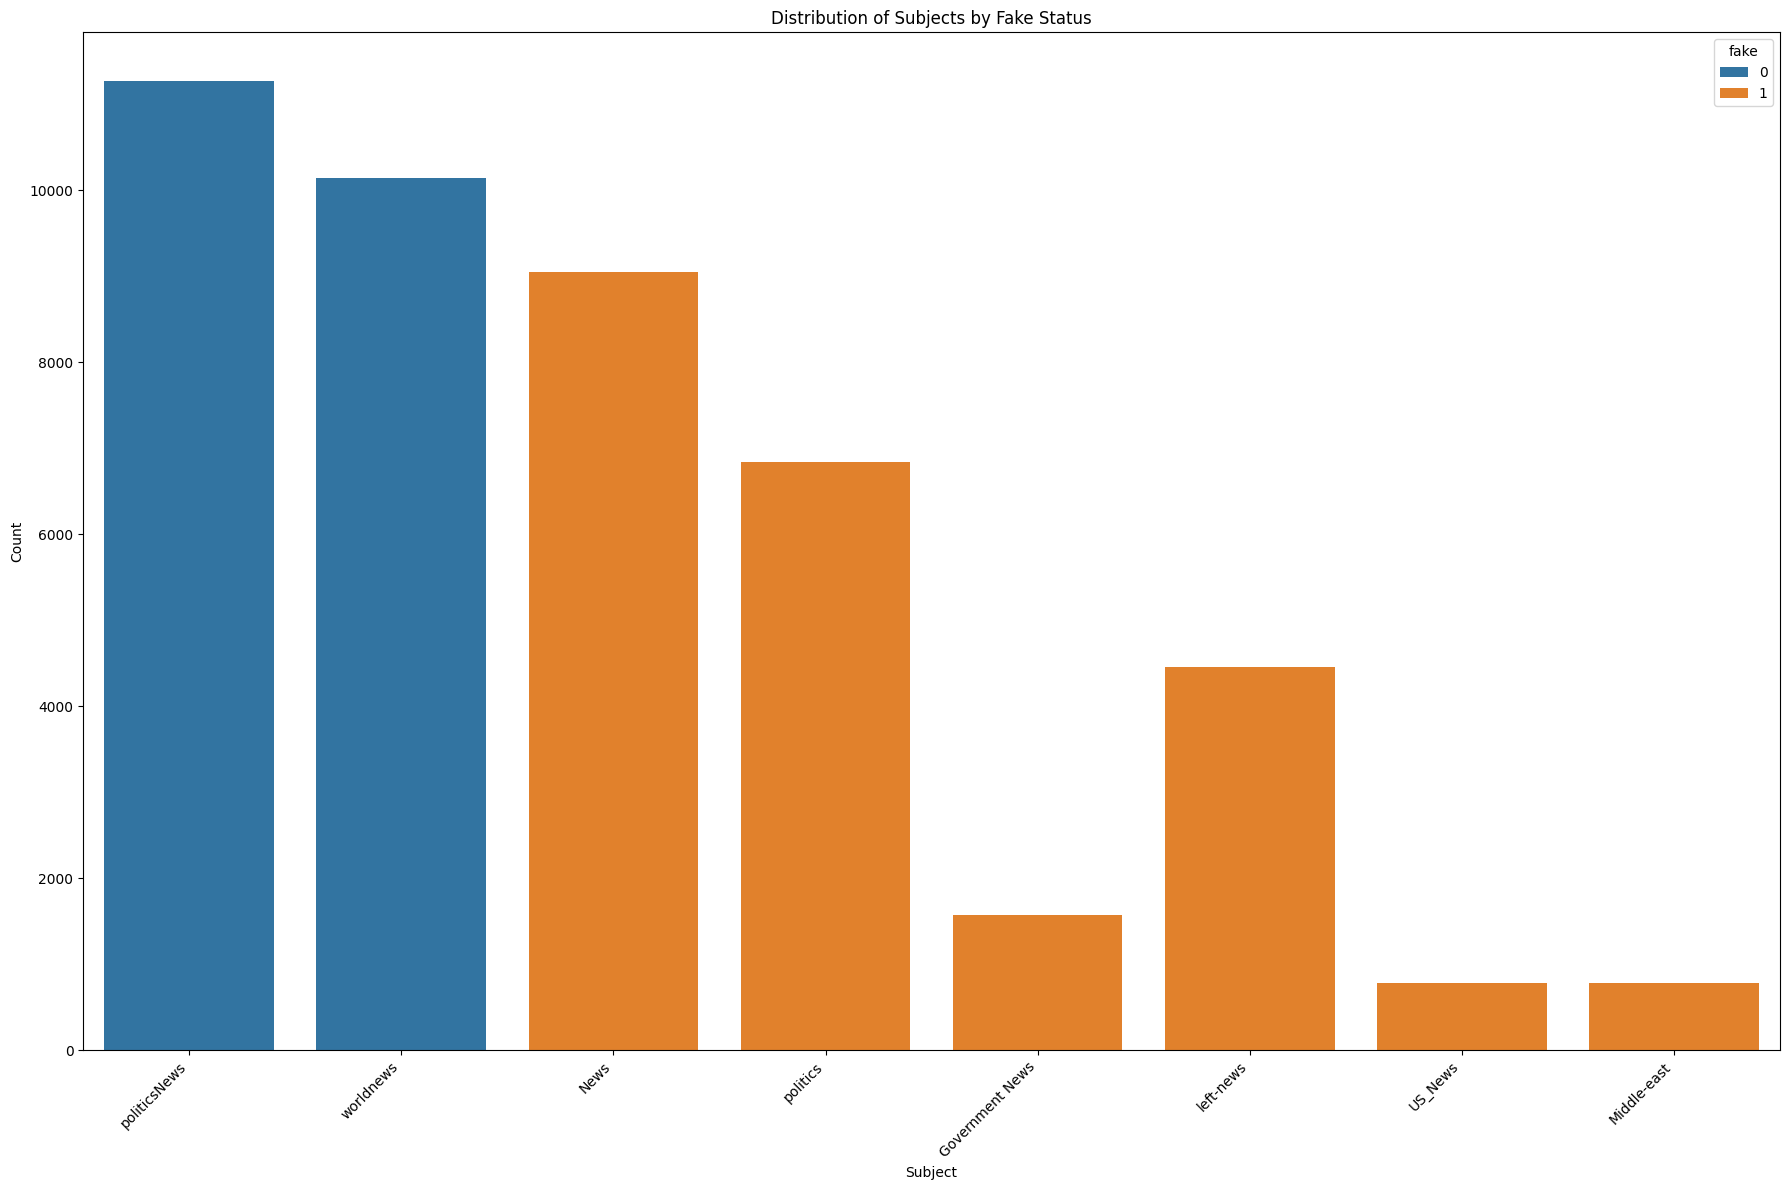

In [14]:
plt.figure(figsize=(18, 12))
sns.countplot(x="subject", hue="fake", data=news_data)
plt.title("Distribution of Subjects by Fake Status")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

It looks like we have different `subjects` in the two dataframes, keeping the values untouched would introduce a bias in out model, so we should either discard this info or reassign new subjects from a common list to the articles.

In [15]:
news_data.sample(n=20)

,title,text,subject,date,fake
31302,CNN Cuts Off Black Trump Supporter When He Ans...,CNN uses their go-to move when they don t like...,politics,NaT,1
5707,"U.S., South Korea agree to deploy THAAD this y...",SEOUL (Reuters) - U.S. and South Korean defens...,politicsNews,2017-02-03,0
4251,U.S. State Dept keeps hiring freeze as Tillers...,WASHINGTON (Reuters) - U.S. Secretary of State...,politicsNews,2017-04-13,0
10532,U.S. senators urge Obama to push for female U....,UNITED NATIONS/WASHINGTON (Reuters) - Seven U....,politicsNews,2016-03-03,0
29907,Ammon Bundy Has Suddenly Had A Change Of Hear...,"On Tuesday night, seven of the Bundy militants...",News,2016-01-27,1
29254,"Greedy Oil CEO Fires 20 Percent Of Employees,...","The World s largest oil field service, Schlumb...",News,2016-02-26,1
42866,EXPOSE THE LIES: Shut Down Planned Parenthood’...,TODAY IS SCHEDULE YOUR MAMMOGRAM DAY WITH PL...,left-news,NaT,1
41504,WIKILEAKS BOMBSHELL RELEASE: #Unfit Hillary’s ...,Hillary Clinton adviser Philippe Reines at the...,left-news,NaT,1
8005,Federal judge limits some Election Day voter r...,CHICAGO (Reuters) - A federal judge in Illinoi...,politicsNews,2016-09-27,0
37584,REPORT: FBI DIRECTOR COMEY Blocked By Obama Ad...,Comey would likely have pitched the op-ed to T...,Government News,NaT,1


### ***2. Cleaning and Preprocessing***

We cleaned the data to boost quality, converting date strings into datetime objects for time-based analysis, removing rows with invalid dates or missing text, and dropping duplicate articles based on body text. This mattered because messy or repeated data could confuse the model and skew predictions—duplicates, for instance, might overemphasize certain stories.

Noticing that true news often starts with a location and agency like "(Reuters) -", we extracted these as `place` and `broadcaster` features and stripped them from the text. This prevented the model from relying on metadata shortcuts, like "Reuters" signaling truth, and forced it to focus on content instead.

***Density of News by Date***

We plot the distribution of news by label through timeline, it might help to isolate the context of the datasets.

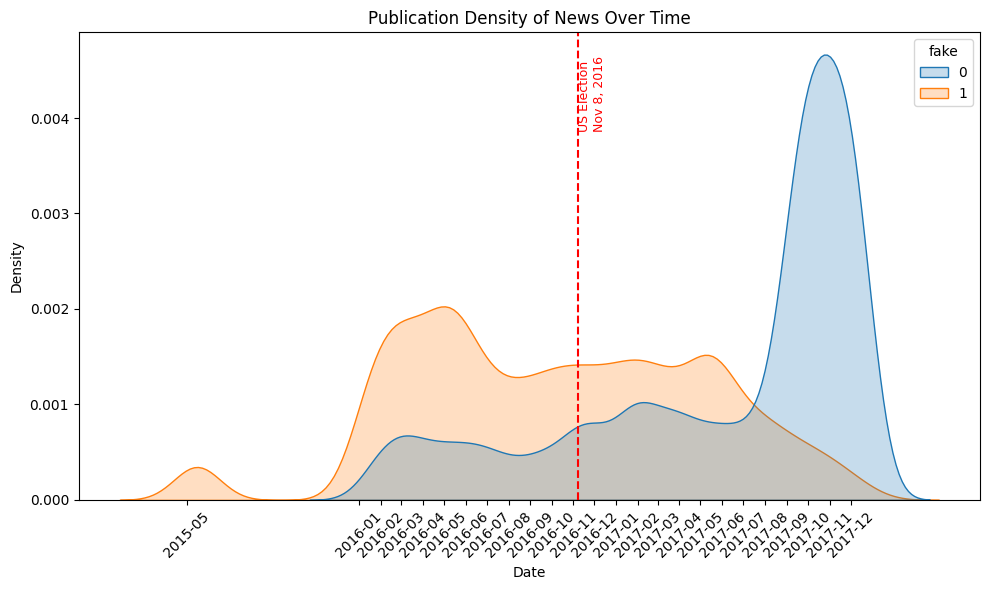

In [28]:
df_cleaned = news_data.dropna(subset=["date"]).copy()
df_cleaned["fake"] = df_cleaned["fake"].astype("category")

df_cleaned["month_year"] = df_cleaned["date"].dt.to_period("M").astype(str)
df_cleaned["date_ordinal"] = df_cleaned["date"].apply(lambda x: x.toordinal())

df_cleaned = df_cleaned.sort_values("date_ordinal")

unique_month_years = df_cleaned["month_year"].unique()
unique_ordinals = df_cleaned.groupby("month_year")["date_ordinal"].first().values

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cleaned, x="date_ordinal", hue="fake", fill=True, common_norm=False)

# Add US election vertical line (Nov 8, 2016)
election_date = pd.to_datetime("2016-11-08").toordinal()
plt.axvline(x=election_date, color='red', linestyle='--', linewidth=1.5)
plt.text(election_date, plt.ylim()[1]*0.95, 'US Election\nNov 8, 2016',
         color='red', rotation=90, verticalalignment='top', fontsize=9)

plt.xticks(ticks=unique_ordinals, labels=unique_month_years, rotation=45)
plt.title("Publication Density of News Over Time")
plt.xlabel("Date")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

We see a very different distribution of articles by date. This could be due to how the data was collected more than to some meaningful behavior. The model could be biased by this distribution if we keep the info.

***Uneven Titles Formatting***

When inspecting the head of the two datasets we noticed that true news have an initial reference to place and agency, while this info is missing from the fake ones. To prevent introducing a bias in our model we will add a new field where this info is removed.

In [17]:
broadcaster_pattern = r"\(([A-Z][A-Za-z\s.-]{1,30})\)\s-\s"


def extract_place_broadcaster(text, pattern):
    match = re.search(pattern, text)
    if match:
        broadcaster = match.group(1).strip()

        if not re.match(r"^[A-Z][A-Za-z\s.-]{1,30}$", broadcaster):
            return None, None, text

        pre_broadcaster_text = text[: match.start()].strip()
        place = pre_broadcaster_text if pre_broadcaster_text else None

        cleaned_text = text[match.end() :].strip()

        return place, broadcaster, cleaned_text

    return None, None, text

In [18]:
news_data["original_text"] = news_data["text"]

news_data["place"], news_data["broadcaster"], news_data["text"] = zip(
    *news_data["text"].apply(
        lambda x: extract_place_broadcaster(str(x), broadcaster_pattern)
    )
)

In [19]:
news_data.sample(n=5)

,title,text,subject,date,fake,original_text,place,broadcaster
4129,"Waiting for green cards, Indian visa-holders s...",When Gokul Gunasekaran was offered a full scho...,politicsNews,2017-04-21,0,SAN FRANCISCO (Reuters) - When Gokul Gunasekar...,SAN FRANCISCO,Reuters
7946,Clinton: My worries are not the same as black ...,Hillary Clinton told a majority-black church i...,politicsNews,2016-10-02,0,"CHARLOTTE, N.C. (Reuters) - Hillary Clinton to...","CHARLOTTE, N.C.",Reuters
873,"Powell rose to top of Trump's list as safe, sa...",Jerome Powell was not on President Donald Trum...,politicsNews,2017-11-02,0,WASHINGTON/NEW YORK (Reuters) - Jerome Powell ...,WASHINGTON/NEW YORK,Reuters
10589,Nobel laureate Vargas Llosa calls Trump a 'clo...,Peruvian Nobel prize-winning author Mario Varg...,politicsNews,2016-03-01,0,MADRID (Reuters) - Peruvian Nobel prize-winnin...,MADRID,Reuters
22162,Top Republican Senator BLISTERS Trump For Dem...,It s official. Donald Trump is losing Republic...,News,2017-07-25,1,It s official. Donald Trump is losing Republic...,None,None


In [20]:
news_data["broadcaster"].value_counts()

broadcaster
Reuters                       21246
Thomson Reuters Foundation        7
IFR                               3
Reuters on Friday                 1
Name: count, dtype: int64

***Duplicated Records***

It is time now to address duplicate articles. We saw that the values differ for title and text fields, it means that there might be different bodies with the same title or different titles assigned to the same body. 

The current strategy is to only remove duplicate text and then concatenate title and text in a single feature. We decided not to remove title, because the tone, the form, the words used in fake news titles can be useful during training.

In [21]:
# Identify texts that appear more than once in both datasets
news_duplicate_texts = news_data[news_data["text"].duplicated(keep=False)]

# Check the top repeated texts and their associated metadata
news_duplicate_summary = (
    news_duplicate_texts.groupby("text")
    .agg(
        {
            "title": lambda x: list(x),
            "subject": lambda x: list(x),
            "date": lambda x: list(x),
            "fake": lambda x: list(x),
        }
    )
    .reset_index()
)

# Sort by the number of occurrences
news_duplicate_summary["count"] = news_duplicate_summary["title"].apply(len)

# Display the most duplicated texts
top_news_duplicates = news_duplicate_summary.sort_values(
    by="count", ascending=False
).head(5)

top_news_duplicates

,text,title,subject,date,fake,count
0,,"[Graphic: Supreme Court roundup, TAKE OUR POLL...","[politicsNews, politics, politics, politics, p...","[2016-06-16 00:00:00, 2017-05-10 00:00:00, NaT...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",627
1938,Highlights for U.S. President Donald Trump’s a...,[Highlights: The Trump presidency on April 13 ...,"[politicsNews, politicsNews, politicsNews, pol...","[2017-04-13 00:00:00, 2017-04-13 00:00:00, 201...","[0, 0, 0, 0, 0, 0, 0, 0]",8
1937,Highlights for U.S. President Donald Trump’s a...,[Highlights: The Trump presidency on April 21 ...,"[politicsNews, politicsNews, politicsNews, pol...","[2017-04-21 00:00:00, 2017-04-21 00:00:00, 201...","[0, 0, 0, 0, 0]",5
1940,Highlights of the day for U.S. President Donal...,[Highlights: The Trump presidency on March 31 ...,"[politicsNews, politicsNews, politicsNews, pol...","[2017-03-31 00:00:00, 2017-03-31 00:00:00, 201...","[0, 0, 0, 0, 0]",5
857,AP News The regulars amble in before dawn and...,[WHY THIS Democrat Stronghold County Voted For...,"[politics, politics, left-news, left-news]","[NaT, NaT, NaT, NaT]","[1, 1, 1, 1]",4


It seems we have missed detecting empty text in our dataframe when checking for null values. We will drop empty news and then duplicates.


In [22]:
news_data = news_data[news_data["text"].str.strip() != ""].copy()

news_data = news_data.drop_duplicates(subset=["text"], keep="first").reset_index(
    drop=True
)

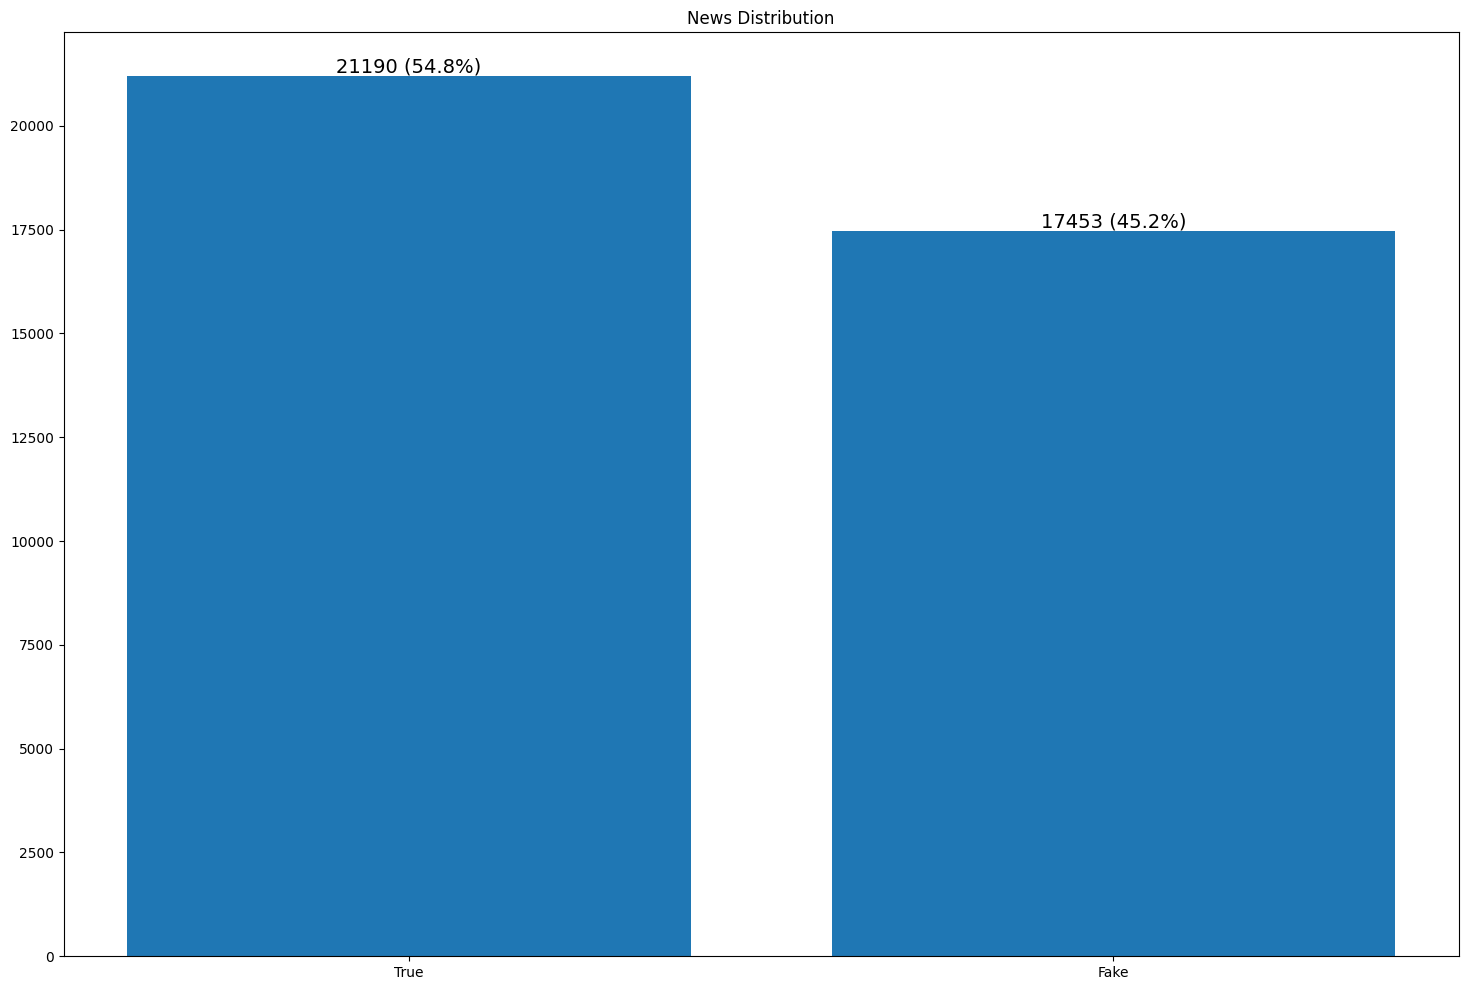

In [23]:
plt.figure(figsize=(18, 12))
news_counts = news_data["fake"].value_counts().sort_index()
news_labels = list(FAKE_MAP.values())
total_gender = news_counts.sum()
bars = plt.bar(news_labels, news_counts)
for i, count in enumerate(news_counts):
    percentage = (count / total_gender) * 100
    plt.text(
        i, count, f"{count} ({percentage:.1f}%)", ha="center", va="bottom", fontsize=14
    )
plt.title("News Distribution")
plt.show()

We have a totally new distribution now, fake news were the majority before cleaning, now they are less than true ones. 

### ***3. Feature Engineering – Statistical Features***

We calculated word counts for titles and article bodies to explore trends, such as whether fake news tends to be wordier or uses flashier titles. These metrics gave us numerical patterns to feed into machine learning models later on.

We filtered out articles under 19 words—often just YouTube links or one-liners—since they offered little for the model to learn from and risked skewing the data with noise or imbalance.

***Titles and Texts Length***

Let's evaluate if there are differences in the word counts of `True` news vs `Fake` news.

In [24]:
news_data["title_length"] = news_data["title"].apply(lambda x: len(str(x).split()))
news_data["text_length"] = news_data["text"].apply(lambda x: len(str(x).split()))

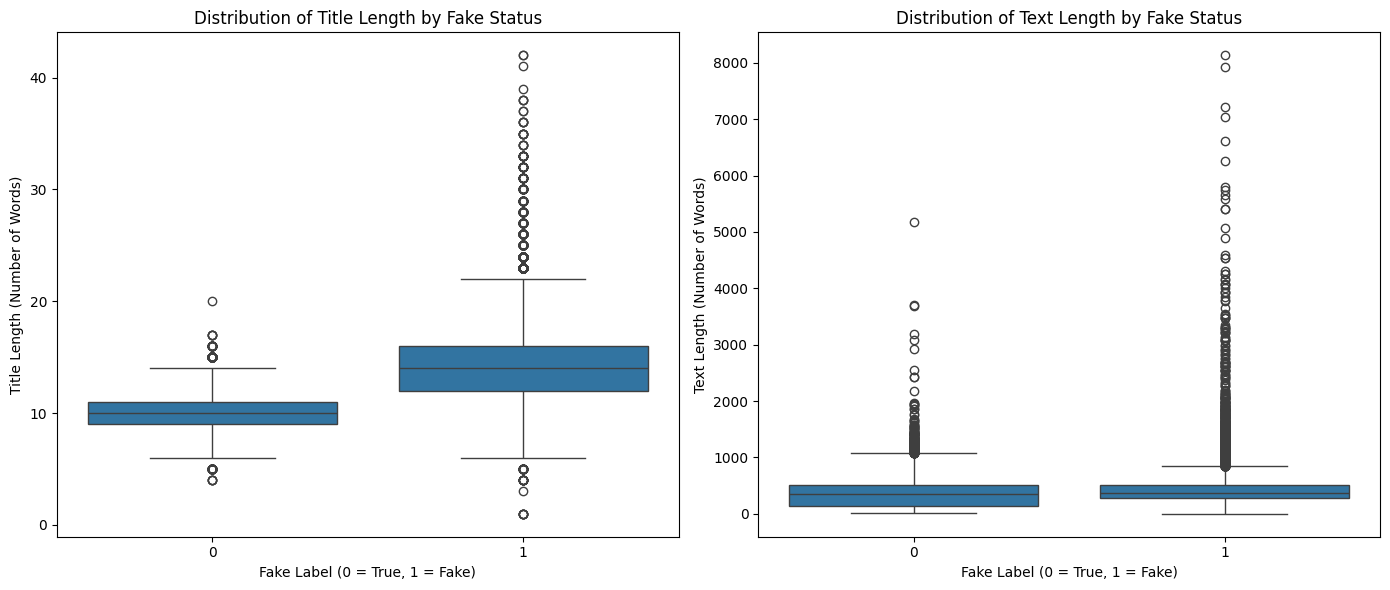

In [25]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=news_data, x="fake", y="title_length")
plt.title("Distribution of Title Length by Fake Status")
plt.xlabel("Fake Label (0 = True, 1 = Fake)")
plt.ylabel("Title Length (Number of Words)")

plt.subplot(1, 2, 2)
sns.boxplot(data=news_data, x="fake", y="text_length")
plt.title("Distribution of Text Length by Fake Status")
plt.xlabel("Fake Label (0 = True, 1 = Fake)")
plt.ylabel("Text Length (Number of Words)")

plt.tight_layout()
plt.show()

In [26]:
title_length_stats = news_data.groupby("fake")["title_length"].describe()
text_length_stats = news_data.groupby("fake")["text_length"].describe()

print("Title Length Summary Statistics:")
display(title_length_stats)

print("\nText Length Summary Statistics:")
display(text_length_stats)

Title Length Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
fake,,,,,,,,
0,21190.0,9.951203,1.698852,4.0,9.0,10.0,11.0,20.0
1,17453.0,14.317825,3.955923,1.0,12.0,14.0,16.0,42.0



Text Length Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
fake,,,,,,,,
0,21190.0,381.574894,273.615045,19.0,144.0,355.0,519.0,5170.0
1,17453.0,425.305850,355.188482,1.0,277.0,376.0,503.0,8135.0


It seems fake news tent to be more verbose than true ones, and we have really long texts, even 8 times longer than upper whisker. We will probably be clipping the longest texts, so we won't discard them as outliers. Bigger concern comes from the shortest articles, 1 or 2 words are surely not valid examples of news. Furthermore the lowest limit for true news is 19, so to prevent bias based on text length we will discard all news shorter than 19. But let's have an eye on the content we will be discarding.

In [27]:
short_texts = news_data[news_data["text_length"] < 19]
short_texts_sample = short_texts[["title", "text", "subject", "date", "fake"]].head(20)
short_texts_count = short_texts["fake"].value_counts()

print(f"Total short texts (≤10 words): {len(short_texts)}")
print("Distribution by fake status (0 = True, 1 = Fake):")
print(short_texts_count)
print("\nSample of Short Texts:")
display(short_texts_sample)

Total short texts (≤10 words): 333
Distribution by fake status (0 = True, 1 = Fake):
fake
1    333
Name: count, dtype: int64

Sample of Short Texts:


,title,text,subject,date,fake
30547,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,1
32302,MY FAVORITE EXCUSES…Featuring Hillary Rotten C...,Enjoy:,politics,NaT,1
32416,JUDGE JEANINE’S OPENING STATEMENT: “Our Presid...,Watch my #OpeningStatment pic.twitter.com/Qp...,politics,NaT,1
32430,MELANIA TRUMP GIVES POWERFUL SPEECH to Honor ‘...,https://www.youtube.com/watch?v=cJZFepSvxzM,politics,NaT,1
32455,KELLYANNE CONWAY: Here’s My Favorite SNL Skit!...,We have to agree that this one is actually pre...,politics,NaT,1
32460,TERRORISM EXPERT SEBASTIAN GORKA On What Next ...,https://www.youtube.com/watch?v=-7Tn4gi_Os8,politics,NaT,1
32462,TRUMP CABINET MEMBER MICK MULVANEY ON DC: “Thi...,https://www.youtube.com/watch?time_continue=2&...,politics,NaT,1
32478,CRYBABY NANCY PELOSI Taunts Trump On Healthcar...,https://www.youtube.com/watch?v=SH0pRtK9sAE,politics,NaT,1
32479,SARA CARTER AND JAY SEKULOW With The Latest On...,https://www.youtube.com/watch?v=DRLVvYzG46w,politics,NaT,1
32484,HYSTERICAL! HERE’S WHY TRUMP SAID TO REPORTER:...,Read more:WT,politics,NaT,1


It seems most of them are just links to videos, which are not useful for our analysis. We will remove these short texts from the dataset.

In [28]:
news_data = news_data[(news_data["text_length"] >= 19)].copy()

# Verify the updated length distribution
print(news_data["text_length"].describe())
print(news_data["fake"].value_counts())

count    38310.000000
mean       404.731637
std        313.069716
min         19.000000
25%        220.000000
50%        369.000000
75%        512.000000
max       8135.000000
Name: text_length, dtype: float64
fake
0    21190
1    17120
Name: count, dtype: int64


### ***4. Sentiment Analysis***

We applied VADER sentiment scores to titles and text, testing our hunch that fake news leans on emotional language, especially in headlines. This helped us capture stylistic differences that could hint at psychological tactics.

***Title Sentiment Analysis***

Since fake news tend to have clickbaiting titles and interjective words, we expect to have extreme values.

In [29]:
sia = SentimentIntensityAnalyzer()


def title_sentiment_analysis(title):
    sentiment = sia.polarity_scores(title)["compound"]
    return sentiment


news_data["title_sentiment"] = news_data["title"].apply(title_sentiment_analysis)

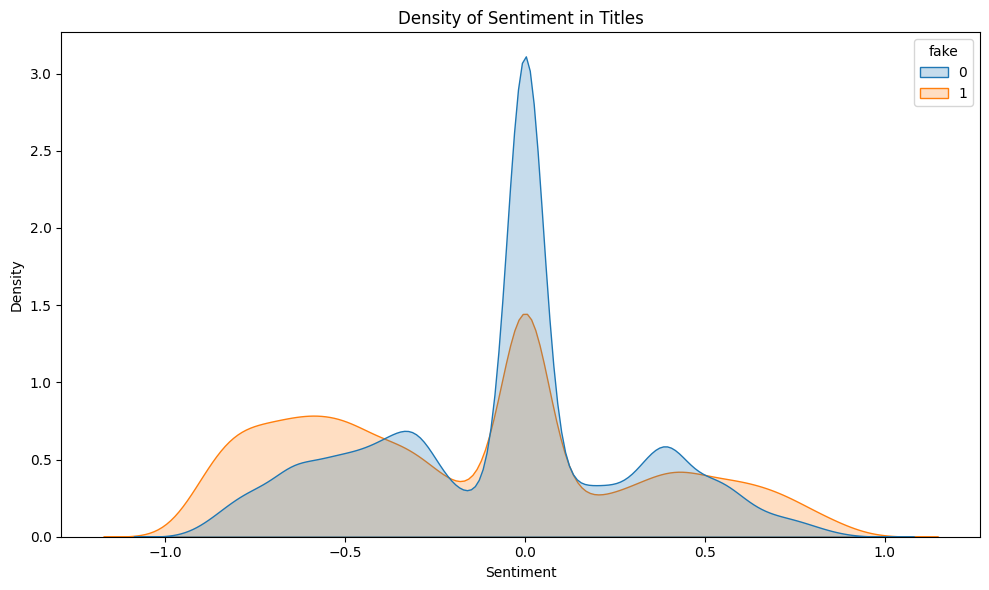

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=news_data, x="title_sentiment", hue="fake", fill=True, common_norm=False
)

plt.title("Density of Sentiment in Titles")
plt.xlabel("Sentiment")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

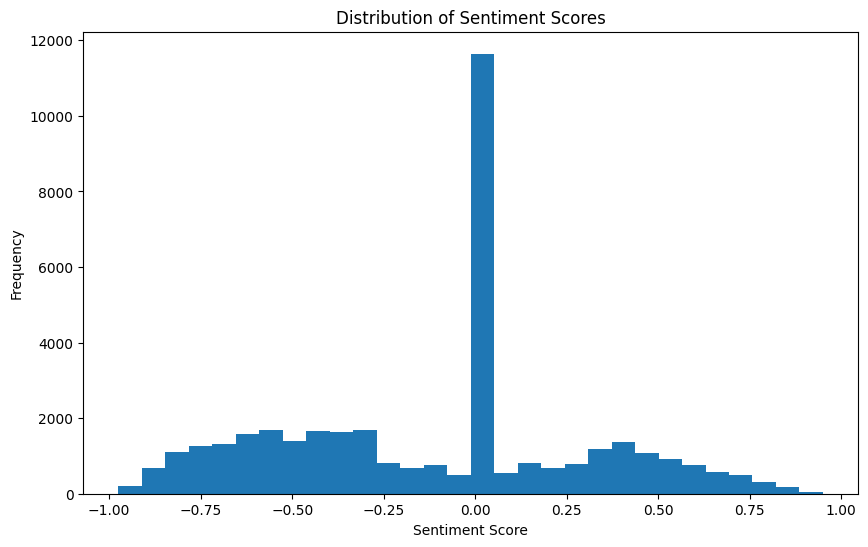

In [31]:
# Plotting the distribution of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(news_data["title_sentiment"], bins=30)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

The distribution is very interesting, the VADER score seems to detect either 0 or consistent positive/negative value, as expected fake news seem to be less neutral, but the difference is smaller than estimated.

***Text Sentiment Analysis***

We replicate the same analysis on the content of the articles, having more content to process the results might be quite different than previous ones.

In [32]:
news_data["text_sentiment"] = news_data["text"].apply(title_sentiment_analysis)

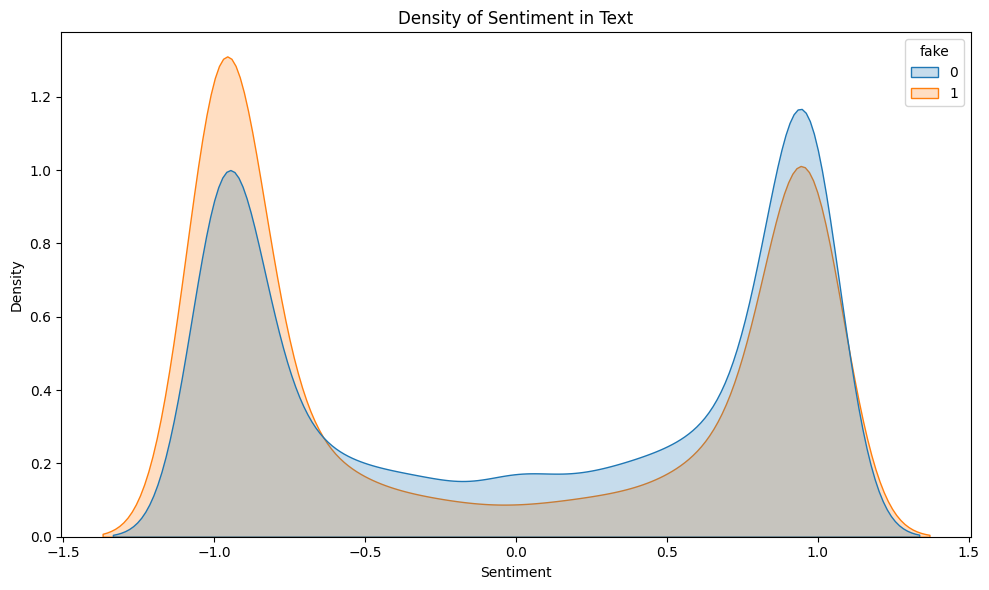

In [33]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=news_data, x="text_sentiment", hue="fake", fill=True, common_norm=False
)

plt.title("Density of Sentiment in Text")
plt.xlabel("Sentiment")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

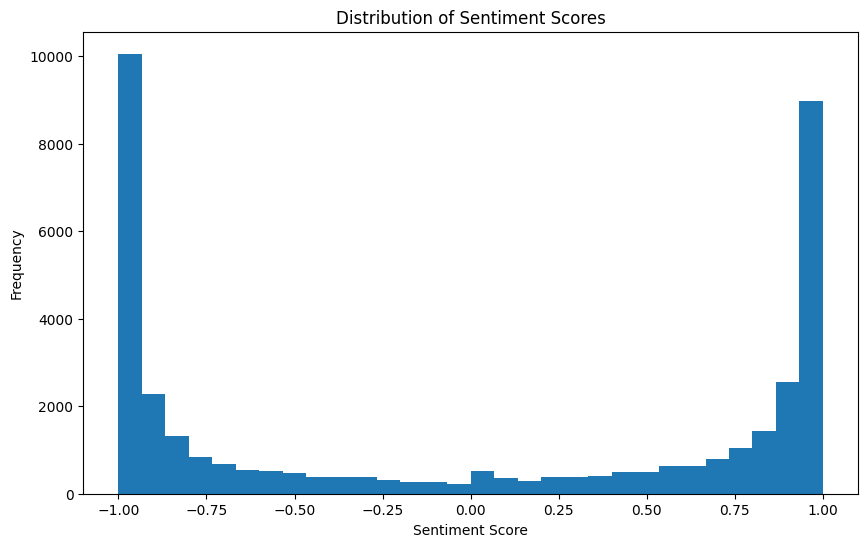

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(news_data["text_sentiment"], bins=30)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

The distribution is the opposite than titles, the peaks now are at the extremes not in the center. Fake news ride negative sentiments more than true, but the difference is smaller than in our expectations.

### ***5. Readability and Clickbait Detection***

We measured readability with Flesch-Kincaid scores and flagged clickbait traits, like excessive punctuation, uppercase letters, and words like "shocking", combining them into a clickbaitiness score. This reflected fake news preference for grabbing attention over delivering facts.

***Readability Score***

The Flesch-Kincaid Grade Level and Flesch Reading Ease metrics evaluate the readability of a text by analyzing its sentence length and word complexity (measured by syllable count). Together, they estimate how easy or difficult a passage is to understand, and usually fake news tent to use a more familiar language rather than professional, this could mirror in these metrics.

In [35]:
news_data["flesch_kincaid_grade"] = news_data["text"].apply(
    textstat.flesch_kincaid_grade
)
news_data["flesch_reading_ease"] = news_data["text"].apply(textstat.flesch_reading_ease)

***Titles Clickbait Score***

Fake news are well known for their extensive use of clickbaiting titles. This effect is usually achieved through the use of specific keywords, capitalized words or repetitive punctuation. We try to esimate a score.

In [ ]:
news_data["clickbait_score"] = news_data["title"].apply(
    lambda x: x.count("!")
    + x.count("?")
    + sum(
        1
        for word in x.split()
        if word.lower()
        in [
            "shocking",
            "amazing",
            "incredible",
            "unbelievable",
            "viral",
            "click",
            "watch",
            "uncensored",
            "listen",
            "stolen",
            "nsfw",
            "exclusive",
            "you won't believe",
        ]
    )
)

We go a step further adding title sentiment score in the computation.

In [37]:
news_data["exclamation_count"] = news_data["title"].apply(lambda x: x.count("!"))
news_data["question_count"] = news_data["title"].apply(lambda x: x.count("?"))
news_data["uppercase_ratio"] = news_data["title"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

news_data["clickbaitiness_score"] = (
    news_data["title_sentiment"].abs()
    * (news_data["exclamation_count"] + news_data["question_count"])
    * (1 + news_data["uppercase_ratio"])
)

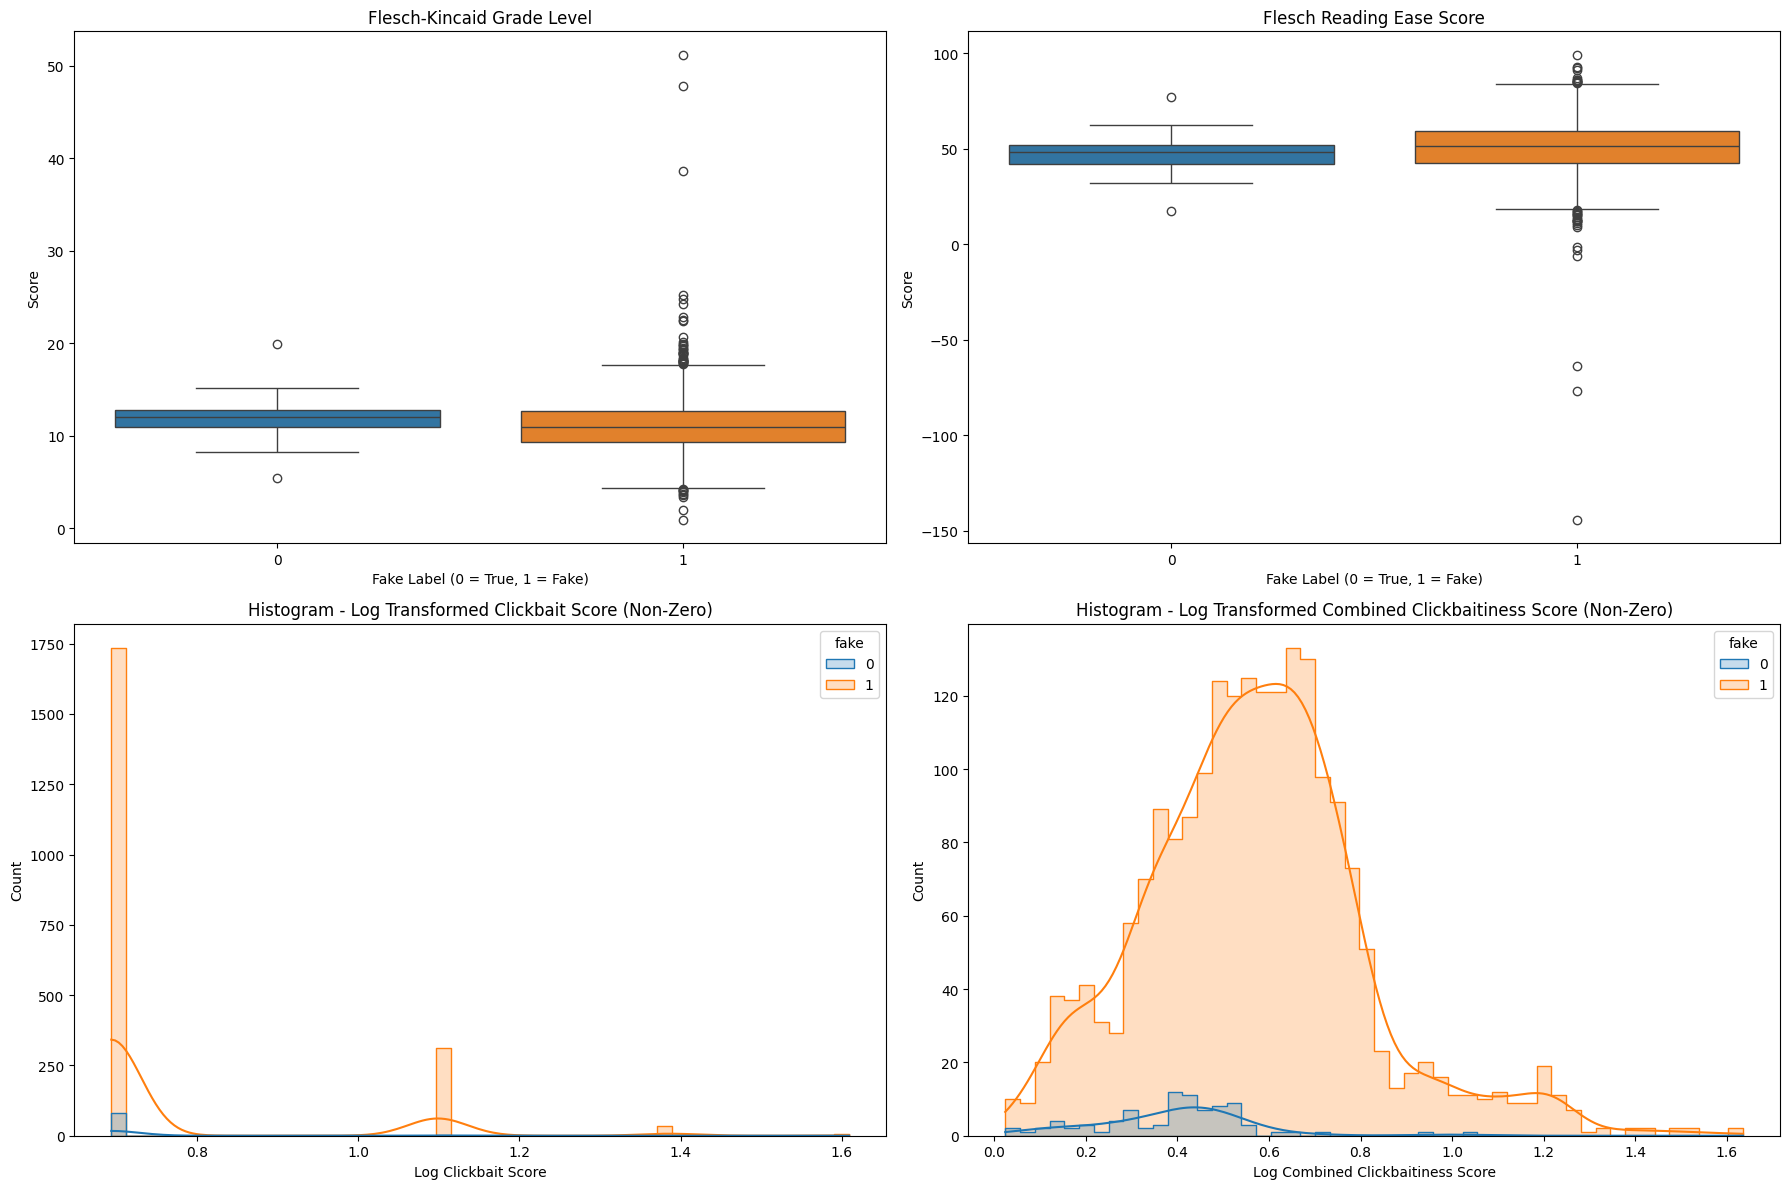

In [38]:
non_zero_data = news_data[
    (news_data["clickbait_score"] > 0) & (news_data["clickbaitiness_score"] > 0)
].copy()

# Apply a small offset and log transformation to avoid log(0) issues
non_zero_data["clickbait_score_log"] = np.log1p(non_zero_data["clickbait_score"])
non_zero_data["clickbaitiness_score_log"] = np.log1p(
    non_zero_data["clickbaitiness_score"]
)

plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
sns.boxplot(
    data=non_zero_data, x="fake", y="flesch_kincaid_grade", hue="fake", legend=False
)
plt.title("Flesch-Kincaid Grade Level")
plt.xlabel("Fake Label (0 = True, 1 = Fake)")
plt.ylabel("Score")

plt.subplot(2, 2, 2)
sns.boxplot(
    data=non_zero_data, x="fake", y="flesch_reading_ease", hue="fake", legend=False
)
plt.title("Flesch Reading Ease Score")
plt.xlabel("Fake Label (0 = True, 1 = Fake)")
plt.ylabel("Score")

plt.subplot(2, 2, 3)
sns.histplot(
    data=non_zero_data,
    x="clickbait_score_log",
    hue="fake",
    bins=50,
    kde=True,
    element="step",
    fill=True,
)
plt.title("Histogram - Log Transformed Clickbait Score (Non-Zero)")
plt.xlabel("Log Clickbait Score")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
sns.histplot(
    data=non_zero_data,
    x="clickbaitiness_score_log",
    hue="fake",
    bins=50,
    kde=True,
    element="step",
    fill=True,
)
plt.title("Histogram - Log Transformed Combined Clickbaitiness Score (Non-Zero)")
plt.xlabel("Log Combined Clickbaitiness Score")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### ***6. Media & Tag Detection in Titles***

We spotted tags like `[VIDEO]` or social media mentions in titles, extracting them as flags for video, audio, or authority cues. These hinted at differing strategies that might tie to credibility or manipulation.

***Title Keywords***

Similarly to what we have done with publishers and place, we try to extract the keywords placed in brackets inside the titles. Let's display a list and then decide which ones ahve to be used.

In [39]:
pattern = r"\((.*?)\)|\[(.*?)\]"
matches = news_data["title"].str.findall(pattern)

# Flatten the list of tuples and filter out empty strings
extracted_words = [item for sublist in matches for item in sublist if item]

# Get distinct words
distinct_words = list(set(extracted_words))

# Display the distinct words
display(distinct_words)

[('July 27', ''),
 ('July 9', ''),
 ('Hillary', ''),
 ('', 'Hillary'),
 ('Bans', ''),
 ('July 31', ''),
 ('Oct 9', ''),
 ('', 'Dallas'),
 ('LIVE AUDIO', ''),
 ('HILLARY’S', ''),
 ('1655 GMT', ''),
 ('Dec 27', ''),
 ('December 12', ''),
 ('', 'video'),
 ('Jan 25', ''),
 ('July 12', ''),
 ('And The Walking Dead', ''),
 ('Eric Holder In A Skirt', ''),
 ('Live Video', ''),
 ('Dec 28', ''),
 ('', 'Transcript And Video'),
 ('IMAGES/VIDEOS', ''),
 ('Hint: It’s Not Obama', ''),
 ('In Name Only', ''),
 ('And Why That’s A Good Thing', ''),
 ('August 3', ''),
 ('Aug 18', ''),
 ('April 17', ''),
 ('And Perhaps Greatest', ''),
 ('VIDEO/SCREENSHOTS', ''),
 ('Details', ''),
 ('Hollywood', ''),
 ('1994', ''),
 ('April 11', ''),
 ('TWEET', ''),
 ('VIRAL VIDEO', ''),
 ('half', ''),
 ('Aug 30', ''),
 ('2011', ''),
 ('2008', ''),
 ('Traitors', ''),
 ('September 20', ''),
 ('', 'FLASHBACK VIDEO'),
 ('Aug 24', ''),
 ('May 3', ''),
 ('Nov. 28', ''),
 ('July 11', ''),
 ('Video', ''),
 ('SCREENSHOTS', ''),
 ('

We have dates in an abbreviated form, we will remove it, then we will group the other in macro categories. We will have 3 media flags, one social and one with words that try to mimick some kind of "authority".

In [40]:
video_keywords = {"video", "trailer", "watch"}
audio_keywords = {"audio", "podcast", "listen"}
image_keywords = {"image", "photo", "picture", "pic", "screenshot", "graphic"}
social_keywords = {"tweet", "twitter", "facebook", "social"}
authority_keywords = {"citation", "quote", "detail", "letter"}

date_pattern = re.compile(
    r"\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|sept|oct|nov|dec)[a-z]*\s+\d{1,2}\b|\b\d{4}\b",
    re.IGNORECASE,
)


def extract_features_and_clean(title):
    brackets = re.findall(r"\[.*?\]|\(.*?\)", title)

    has_video = has_audio = has_image = has_social = has_authority = 0

    for br in brackets:
        content = br.strip("[]()").lower()

        if any(key in content for key in video_keywords):
            has_video = 1
            title = title.replace(br, "")
        elif any(key in content for key in audio_keywords):
            has_audio = 1
            title = title.replace(br, "")
        elif any(key in content for key in image_keywords):
            has_image = 1
            title = title.replace(br, "")
        elif any(key in content for key in social_keywords):
            has_social = 1
            title = title.replace(br, "")
        elif any(key in content for key in authority_keywords):
            has_authority = 1
            title = title.replace(br, "")
        elif date_pattern.search(content):
            title = title.replace(br, "")
        else:
            # Keep the content, remove only brackets
            title = title.replace(br, content)

    return pd.Series(
        [has_video, has_audio, has_image, has_social, has_authority, title.strip()]
    )

In [41]:
news_data[
    [
        "has_video",
        "has_audio",
        "has_image",
        "has_social",
        "has_authority",
        "title_cleaned",
    ]
] = (
    news_data["title"].astype(str).apply(extract_features_and_clean)
)

# Preview result
display(
    news_data[
        [
            "title",
            "title_cleaned",
            "has_video",
            "has_audio",
            "has_image",
            "has_social",
            "has_authority",
        ]
    ].sample(10)
)

,title,title_cleaned,has_video,has_audio,has_image,has_social,has_authority
5154,Trump trade office takes aggressive view of WT...,Trump trade office takes aggressive view of WT...,0,0,0,0,0
32504,DISTURBING: Tomi Lahren Panders To “The View” ...,DISTURBING: Tomi Lahren Panders To “The View” ...,0,0,0,0,0
7583,Got bank? Election could create flood of marij...,Got bank? Election could create flood of marij...,0,0,0,0,0
10743,Ex-White House aide and ex-IBM CEO to head cyb...,Ex-White House aide and ex-IBM CEO to head cyb...,0,0,0,0,0
6489,Trump warns Republicans to 'be careful' over O...,Trump warns Republicans to 'be careful' over O...,0,0,0,0,0
13780,U.S. calls on Pakistan to arrest recently free...,U.S. calls on Pakistan to arrest recently free...,0,0,0,0,0
18568,U.S. says countries should suspend providing w...,U.S. says countries should suspend providing w...,0,0,0,0,0
35975,BREAKING: RINO RESIGNS…Boehner Announces He’s ...,BREAKING: RINO RESIGNS…Boehner Announces He’s ...,0,0,0,0,0
17026,Ex-soccer star 'King George' nears goal of Lib...,Ex-soccer star 'King George' nears goal of Lib...,0,0,0,0,0
30303,ISRAEL WILL NAME New Train Station Near Wester...,ISRAEL WILL NAME New Train Station Near Wester...,0,0,0,0,0


In [42]:
news_data.head()

,title,text,subject,date,fake,original_text,place,broadcaster,title_length,text_length,...,exclamation_count,question_count,uppercase_ratio,clickbaitiness_score,has_video,has_audio,has_image,has_social,has_authority,title_cleaned
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,2017-12-31,0,WASHINGTON (Reuters) - The head of a conservat...,WASHINGTON,Reuters,10,746,...,0,0,0.062500,0.0,0,0,0,0,0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,2017-12-29,0,WASHINGTON (Reuters) - Transgender people will...,WASHINGTON,Reuters,9,621,...,0,0,0.062500,0.0,0,0,0,0,0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,2017-12-31,0,WASHINGTON (Reuters) - The special counsel inv...,WASHINGTON,Reuters,10,454,...,0,0,0.116667,0.0,0,0,0,0,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,2017-12-30,0,WASHINGTON (Reuters) - Trump campaign adviser ...,WASHINGTON,Reuters,9,373,...,0,0,0.135593,0.0,0,0,0,0,0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,2017-12-29,0,SEATTLE/WASHINGTON (Reuters) - President Donal...,SEATTLE/WASHINGTON,Reuters,11,849,...,0,0,0.057971,0.0,0,0,0,0,0,Trump wants Postal Service to charge 'much mor...


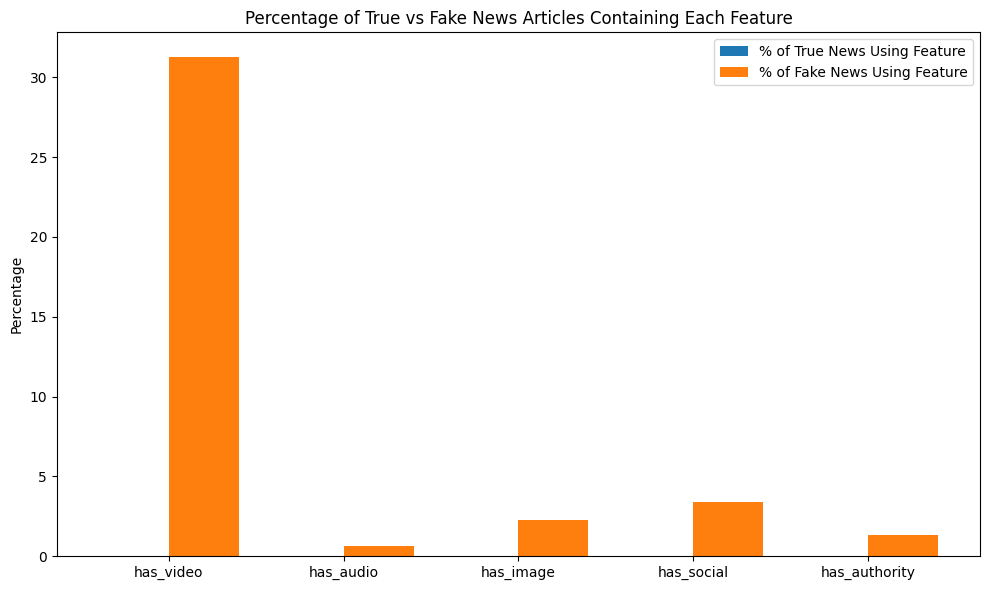

In [43]:
feature_cols = ["has_video", "has_audio", "has_image", "has_social", "has_authority"]
data = []

for feature in feature_cols:
    feature_df = news_data[news_data[feature] == 1]
    total = len(feature_df)
    if total > 0:
        pct_true = (feature_df["fake"] == 0).sum() / total * 100
        pct_fake = (feature_df["fake"] == 1).sum() / total * 100
    else:
        pct_true = pct_fake = 0
    data.append((feature, pct_true, pct_fake))

# Prepare data for plotting
features, true_vals, fake_vals = zip(*data)
x = range(len(features))

feature_true_pct = []
feature_fake_pct = []

true_total = len(news_data[news_data["fake"] == 0])
fake_total = len(news_data[news_data["fake"] == 1])

for feature in feature_cols:
    pct_true_use = (
        news_data[(news_data["fake"] == 0) & (news_data[feature] == 1)].shape[0]
        / true_total
        * 100
    )
    pct_fake_use = (
        news_data[(news_data["fake"] == 1) & (news_data[feature] == 1)].shape[0]
        / fake_total
        * 100
    )
    feature_true_pct.append(pct_true_use)
    feature_fake_pct.append(pct_fake_use)

# Plot complementary chart
plt.figure(figsize=(10, 6))
plt.bar(
    x, feature_true_pct, width=0.4, label="% of True News Using Feature", align="center"
)
plt.bar(
    [i + 0.4 for i in x],
    feature_fake_pct,
    width=0.4,
    label="% of Fake News Using Feature",
    align="center",
)
plt.xticks([i + 0.2 for i in x], features)
plt.ylabel("Percentage")
plt.title("Percentage of True vs Fake News Articles Containing Each Feature")
plt.legend()
plt.tight_layout()
plt.show()

### ***7. Features Correlation***

We have many new numerical features now, let's see if there is a correlation between them and with the target variable.

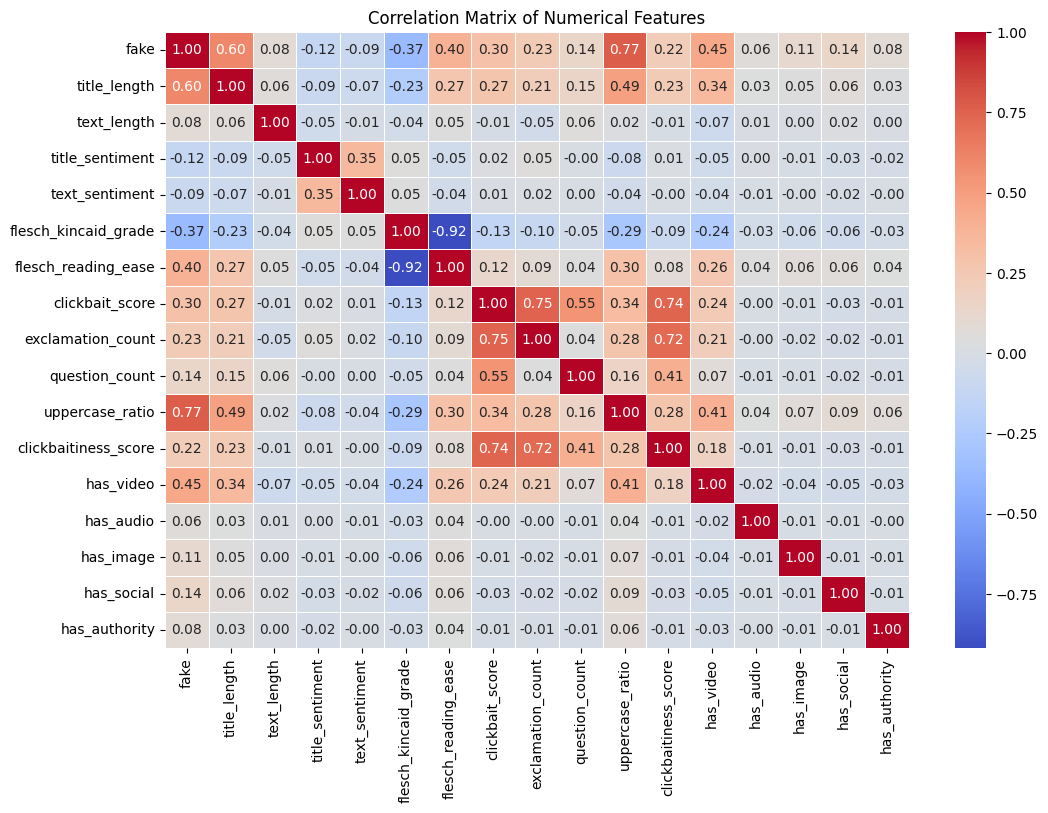

In [44]:
numerical_features = news_data.select_dtypes(include=np.number).columns.tolist()

correlation_matrix = news_data[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

We notice that `uppercase ratio` is the strongest indicator of a fake news status, but title length as well seems to be predictive. The [VIDEO] keyword in title and easiness of reading might be good predictive features as well. We will take this into consideration for our base model.

### ***8. Advanced Text Cleaning***

We merged `title` and `text` into one feature, then scrubbed out URLs, emails, HTML, emojis, and non-ASCII characters. This ensured clean text for accurate NLP processing down the line, whether with BERT or TF-IDF.

In [45]:
URL_EMAIL_PATTERN = re.compile(r"http\S+|www\S+|@\S+")
SOCIAL_MEDIA_PATTERN = re.compile(r"\S+@\S+|@\S+|#\S+")
SPECIAL_CHAR_PATTERN = re.compile(r"[^a-zA-Z0-9\s.,!?\'-]")
HTML_TAG_PATTERN = re.compile(r"<.*?>")
WHITESPACE_PATTERN = re.compile(r"\s+")


def text_cleaning(text):
    """
    Applies basic cleaning: Removes URLs, emails, special characters.
    This is applied to **all models** before further NLP processing.
    """
    if not text:
        return ""

    text = URL_EMAIL_PATTERN.sub("", text)
    text = SOCIAL_MEDIA_PATTERN.sub("", text)
    text = SPECIAL_CHAR_PATTERN.sub("", text)
    text = HTML_TAG_PATTERN.sub("", text)
    text = WHITESPACE_PATTERN.sub(" ", text).strip()

    return text

In [46]:
news_data["combined_text"] = (
    news_data["title_cleaned"].fillna("") + " [SEP] " + news_data["text"].fillna("")
)

news_data["clean_text"] = news_data["combined_text"].apply(text_cleaning)

In [47]:
news_data.sample(n=5)

,title,text,subject,date,fake,original_text,place,broadcaster,title_length,text_length,...,uppercase_ratio,clickbaitiness_score,has_video,has_audio,has_image,has_social,has_authority,title_cleaned,combined_text,clean_text
15111,New Delhi declares emergency as toxic smog thi...,The Indian capital declared a pollution emerge...,worldnews,2017-11-09,0,NEW DELHI (Reuters) - The Indian capital decla...,NEW DELHI,Reuters,11,507,...,0.031746,0.0,0,0,0,0,0,New Delhi declares emergency as toxic smog thi...,New Delhi declares emergency as toxic smog thi...,New Delhi declares emergency as toxic smog thi...
26004,IRS Slams Trump Foundation For Breaking The Law,The Donald J. Trump Foundation just quietly pa...,News,2016-09-01,1,The Donald J. Trump Foundation just quietly pa...,None,None,8,322,...,0.208333,0.0,0,0,0,0,0,IRS Slams Trump Foundation For Breaking The Law,IRS Slams Trump Foundation For Breaking The La...,IRS Slams Trump Foundation For Breaking The La...
38362,New Bill Gates AI-powered ‘Evolv’ Body Scanner...,Beta testing set to begin at transportation hu...,US_News,2016-10-27,1,Beta testing set to begin at transportation hu...,None,None,13,466,...,0.101124,0.0,0,0,0,0,0,New Bill Gates AI-powered ‘Evolv’ Body Scanner...,New Bill Gates AI-powered ‘Evolv’ Body Scanner...,New Bill Gates AI-powered Evolv Body Scanners ...
7922,Obama signs short-term funding bill into law: ...,President Barack Obama on Thursday signed into...,politicsNews,2016-09-29,0,WASHINGTON (Reuters) - President Barack Obama ...,WASHINGTON,Reuters,9,27,...,0.052632,0.0,0,0,0,0,0,Obama signs short-term funding bill into law: ...,Obama signs short-term funding bill into law: ...,Obama signs short-term funding bill into law W...
2061,Britain welcomes Trump's renewed commitment to...,Britain on Tuesday welcomed a commitment by U....,politicsNews,2017-08-22,0,LONDON (Reuters) - Britain on Tuesday welcomed...,LONDON,Reuters,7,154,...,0.051724,0.0,0,0,0,0,0,Britain welcomes Trump's renewed commitment to...,Britain welcomes Trump's renewed commitment to...,Britain welcomes Trump's renewed commitment to...


### ***9. Word Cloud and Vocabulary Analysis***

We generated word clouds and pulled top unigrams, bigrams, and trigrams for both classes, expecting to spot patterns that reveal lexical differences.

***Wordcloud***

We will compare the most common words extracting them from cleaned combined title-text. 

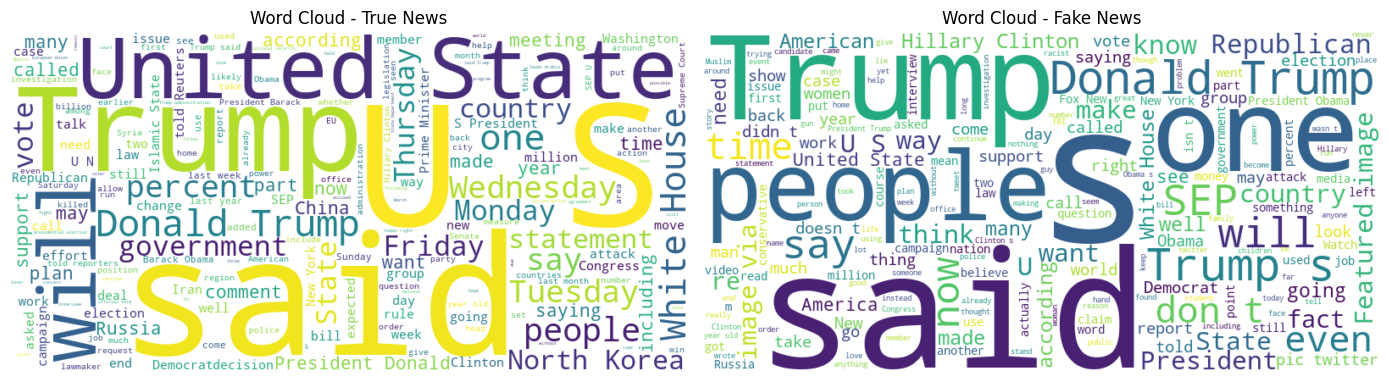

In [48]:
true_news_text = " ".join(news_data[news_data["fake"] == 0]["clean_text"].tolist())
fake_news_text = " ".join(news_data[news_data["fake"] == 1]["clean_text"].tolist())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
wordcloud_true = WordCloud(width=800, height=400, background_color="white").generate(
    true_news_text
)
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - True News")

plt.subplot(1, 2, 2)
wordcloud_fake = WordCloud(width=800, height=400, background_color="white").generate(
    fake_news_text
)
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Fake News")

plt.tight_layout()
plt.show()

Both wordclouds seem to be centered to american politics events, we have names and places together with the word "said", suggesting an extensive use of quoting in the body of the articles.

***Unigrams, Bigrams, Trigrams***

We will extract and display

In [49]:
def compute_top_ngrams(corpus, n=20, max_features=10000):
    """
    Computes the most common unigrams, bigrams, and trigrams in a given corpus.

    Parameters:
    - corpus (list): List of cleaned text.
    - n (int): Number of top N-grams to extract (default: 20).
    - max_features (int): Maximum features for CountVectorizer (default: 10000).

    Returns:
    - dict: Dictionary containing DataFrames with top N-grams for unigrams, bigrams, and trigrams.
    """
    if not corpus:
        raise ValueError("Corpus must not be empty.")

    ngram_settings = {"unigrams": (1, 1), "bigrams": (2, 2), "trigrams": (3, 3)}

    ngram_results = {}

    for key, ngram_range in ngram_settings.items():
        vec = CountVectorizer(
            stop_words="english", ngram_range=ngram_range, max_features=max_features
        ).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

        ngram_results[key] = pd.DataFrame(words_freq, columns=["N-gram", "Frequency"])

    return ngram_results

In [ ]:
true_news_corpus = news_data[news_data["fake"] == 1]["clean_text"].tolist()
fake_news_corpus = news_data[news_data["fake"] == 0]["clean_text"].tolist()

true_news_ngrams = compute_top_ngrams(true_news_corpus, n=20)
fake_news_ngrams = compute_top_ngrams(fake_news_corpus, n=20)

In [51]:
true_uni = true_news_ngrams["unigrams"].rename(
    columns={"N-gram": "True - Unigrams", "Frequency": "True - Freq"}
)
fake_uni = fake_news_ngrams["unigrams"].rename(
    columns={"N-gram": "Fake - Unigrams", "Frequency": "Fake - Freq"}
)

true_bi = true_news_ngrams["bigrams"].rename(
    columns={"N-gram": "True - Bigrams", "Frequency": "True - Freq"}
)
fake_bi = fake_news_ngrams["bigrams"].rename(
    columns={"N-gram": "Fake - Bigrams", "Frequency": "Fake - Freq"}
)

true_tri = true_news_ngrams["trigrams"].rename(
    columns={"N-gram": "True - Trigrams", "Frequency": "True - Freq"}
)
fake_tri = fake_news_ngrams["trigrams"].rename(
    columns={"N-gram": "Fake - Trigrams", "Frequency": "Fake - Freq"}
)

ngram_side_by_side = pd.concat(
    [true_uni, fake_uni, true_bi, fake_bi, true_tri, fake_tri], axis=1
)

display(ngram_side_by_side)
# ngram_side_by_side.to_csv("ngrams_side_by_side.csv", index=False)

,True - Unigrams,True - Freq,Fake - Unigrams,Fake - Freq,True - Bigrams,True - Freq,Fake - Bigrams,Fake - Freq,True - Trigrams,True - Freq,Fake - Trigrams,Fake - Freq
0,trump,73628,said,97822,donald trump,14519,united states,12044,sep donald trump,1370,president donald trump,4405
1,said,24858,trump,47984,featured image,6637,white house,9006,new york times,1149,president barack obama,2036
2,people,21511,president,27463,hillary clinton,5627,donald trump,8008,21st century wire,960,sep president donald,1539
3,president,21425,sep,21191,white house,5418,north korea,5880,black lives matter,905,president donald trumps,1402
4,just,17904,state,20425,united states,4970,president donald,5866,president united states,824,white house said,961
5,sep,17129,government,18630,pic twitter,4885,prime minister,4136,video screen capture,724,president barack obamas,908
6,donald,15899,house,17759,president obama,3577,said statement,3895,image video screen,695,president elect donald,828
7,like,14601,states,17574,new york,3208,new york,3779,president donald trump,683,president vladimir putin,760
8,obama,14502,republican,16713,fox news,2911,islamic state,3657,president barack obama,634,secretary state rex,665
9,clinton,14068,new,16596,president trump,2784,trump said,3523,featured image screenshot,524,state rex tillerson,656


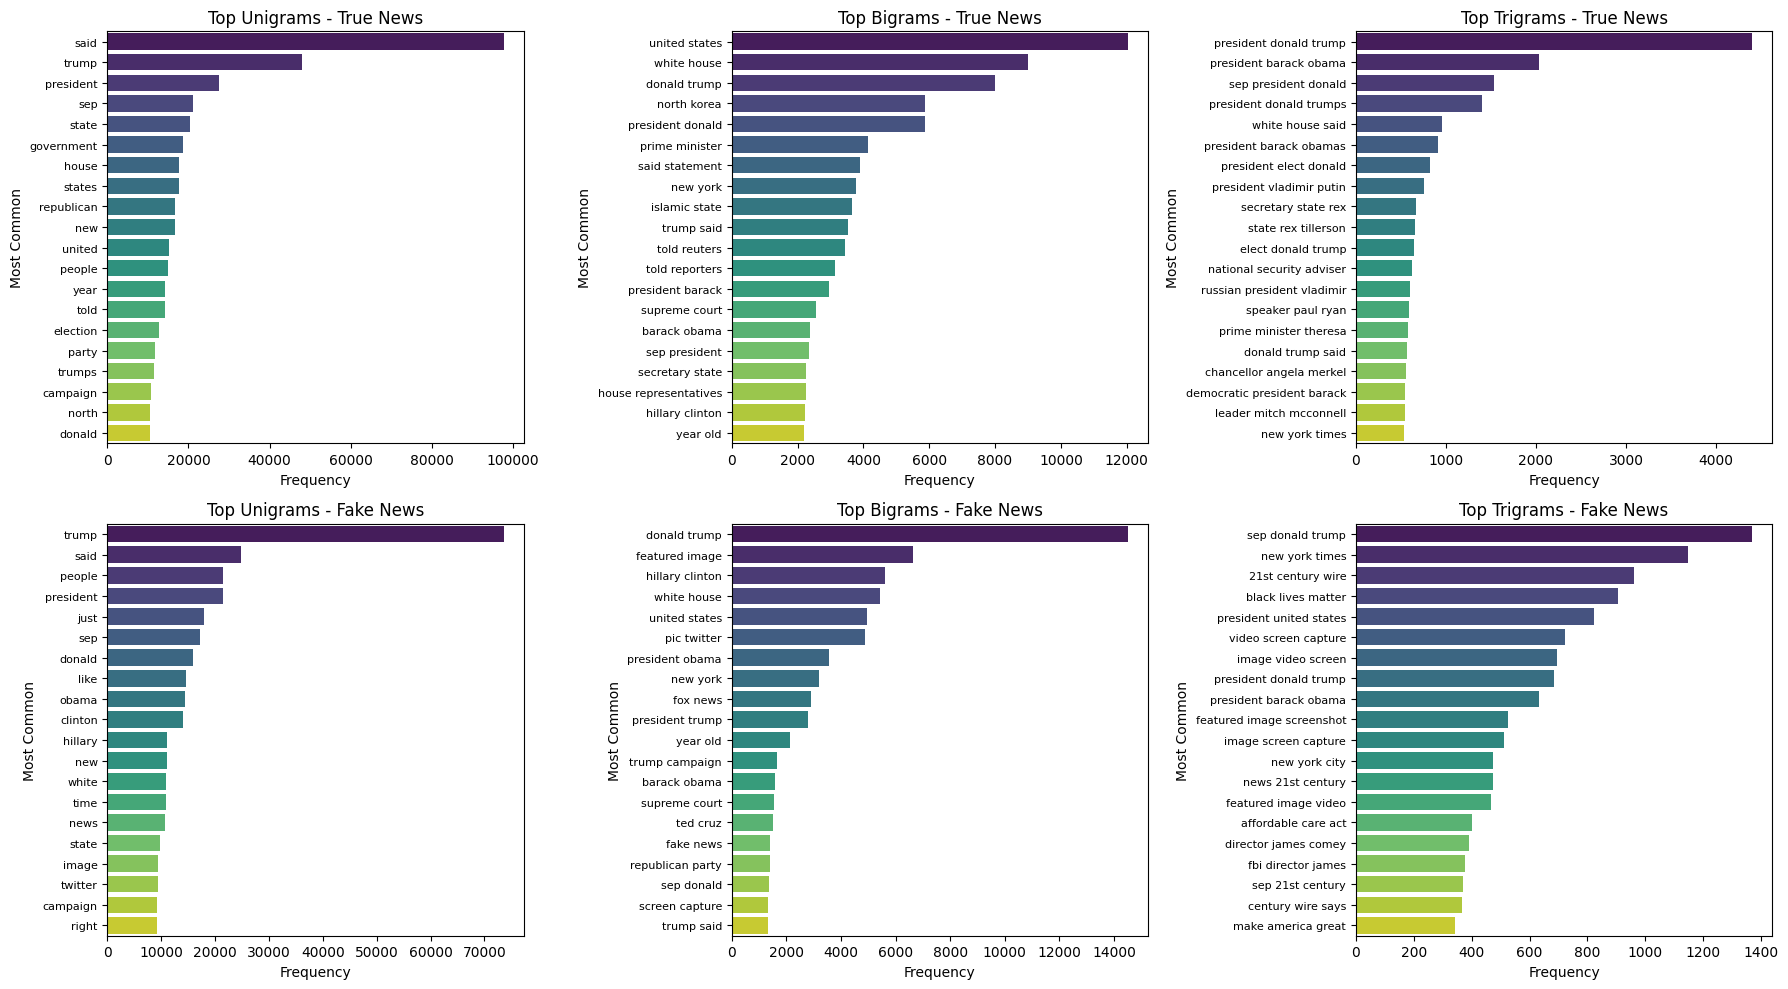

In [52]:
def plot_top_ngrams_grid(true_corpus, fake_corpus, n=20):
    """
    Extracts and visualizes the most common unigrams, bigrams, and trigrams
    for true vs. fake news in a 2x3 grid layout.

    Parameters:
    - true_corpus (list): List of cleaned text from true news.
    - fake_corpus (list): List of cleaned text from fake news.
    - n (int): Number of top N-grams to display (default: 20).
    """
    
    if not true_corpus or not fake_corpus:
        raise ValueError("Corpus lists must not be empty.")

    ngram_settings = [
        {"ngram_range": (1, 1), "title": "Top Unigrams"},
        {"ngram_range": (2, 2), "title": "Top Bigrams"},
        {"ngram_range": (3, 3), "title": "Top Trigrams"},
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.4)

    axes = axes.reshape(2, 3) if axes.ndim == 1 else axes

    for i, settings in enumerate(ngram_settings):
        for j, (corpus, label) in enumerate(
            [(true_corpus, "True News"), (fake_corpus, "Fake News")]
        ):

            vec = CountVectorizer(
                stop_words="english",
                ngram_range=settings["ngram_range"],
                max_features=10000,
            ).fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)

            words_freq = [
                (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
            ]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

            df = pd.DataFrame(words_freq, columns=["N-gram", "Frequency"])

            ax = axes[j, i]
            sns.barplot(
                x="Frequency",
                y="N-gram",
                hue="N-gram",
                data=df,
                palette="viridis",
                ax=ax,
                legend=False,
            )
            ax.set_title(f"{settings['title']} - {label}", fontsize=12)
            ax.set_xlabel("Frequency", fontsize=10)
            ax.set_ylabel("Most Common", fontsize=10)
            ax.tick_params(
                axis="y", labelsize=8
            )

    plt.tight_layout()
    plt.show()

plot_top_ngrams_grid(true_news_corpus, fake_news_corpus, n=20)

***Saving Dataframe***

We saved dataframe in a csv file for further use.

In [53]:
news_data.to_csv("dataset/news_data.csv", index=False)

In [54]:
news_data.head()

,title,text,subject,date,fake,original_text,place,broadcaster,title_length,text_length,...,uppercase_ratio,clickbaitiness_score,has_video,has_audio,has_image,has_social,has_authority,title_cleaned,combined_text,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,2017-12-31,0,WASHINGTON (Reuters) - The head of a conservat...,WASHINGTON,Reuters,10,746,...,0.062500,0.0,0,0,0,0,0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,2017-12-29,0,WASHINGTON (Reuters) - Transgender people will...,WASHINGTON,Reuters,9,621,...,0.062500,0.0,0,0,0,0,0,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,2017-12-31,0,WASHINGTON (Reuters) - The special counsel inv...,WASHINGTON,Reuters,10,454,...,0.116667,0.0,0,0,0,0,0,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator 'Let Mr. Muelle...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,2017-12-30,0,WASHINGTON (Reuters) - Trump campaign adviser ...,WASHINGTON,Reuters,9,373,...,0.135593,0.0,0,0,0,0,0,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,2017-12-29,0,SEATTLE/WASHINGTON (Reuters) - President Donal...,SEATTLE/WASHINGTON,Reuters,11,849,...,0.057971,0.0,0,0,0,0,0,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...


### ***10. Heuristic Model (Baseline Classifier)***

We built a rule-based classifier using features like clickbait scores and uppercase ratios to predict "fake" when thresholds aligned. This gave us a quick benchmark to measure against more complex models.

We have seen that some of the features we have extracted from our dataset might have a predictive weight, so we attempt to define thresholds or values that could help us identify a fake news.
We start by plotting density of the features with highest correlation.

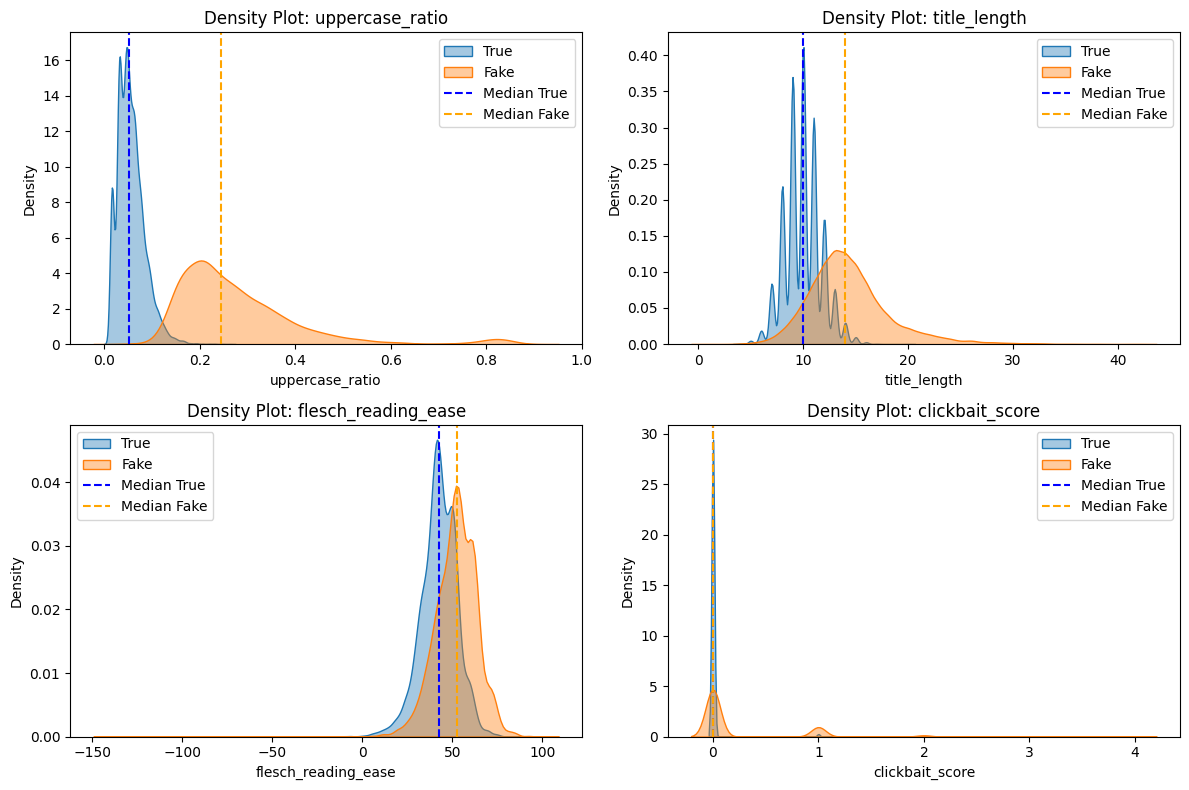

In [ ]:
features_to_plot = [
    "uppercase_ratio",
    "title_length",
    "flesch_reading_ease",
    "clickbait_score",
]
# we will be using has_video as well, but it is a binary feature so no need to define a threshold

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]

    sns.kdeplot(
        data=news_data[news_data["fake"] == 0],
        x=feature,
        label="True",
        fill=True,
        alpha=0.4,
        ax=ax,
    )
    sns.kdeplot(
        data=news_data[news_data["fake"] == 1],
        x=feature,
        label="Fake",
        fill=True,
        alpha=0.4,
        ax=ax,
    )

    ax.axvline(
        news_data[news_data["fake"] == 0][feature].median(),
        color="blue",
        linestyle="--",
        label="Median True",
    )
    ax.axvline(
        news_data[news_data["fake"] == 1][feature].median(),
        color="orange",
        linestyle="--",
        label="Median Fake",
    )

    ax.set_title(f"Density Plot: {feature}")
    ax.legend()

plt.tight_layout()
plt.show()

***Model Definition***

For `uppercase ratio` we will set a default threshold of 0.15, for `title length` 13 words seems reasonable, it is close to fake median, for `FRE` we set 50, for `clickbait score` we have to go with 1, and `has video` flag will be set to 1.

In [10]:
class HeuristicFakeNewsModel:
    def __init__(self, threshold=3):
        """
        Initialize the heuristic model.

        Parameters:
        - threshold (int): Number of rules that must be triggered to predict 'fake'.
        """
        self.threshold = threshold
        self.rules = {
            "uppercase_ratio": 0.15,
            "title_length": 13,
            "flesch_reading_ease": 50,
            "clickbait_score": 1,
            "has_video": 1,
        }

    def _extract_signals(self, row):
        """
        Apply heuristic rules to a single row and count how many fake-news signals are triggered.
        """
        signals = 0
        if row.get("uppercase_ratio", 0) > self.rules["uppercase_ratio"]:
            signals += 1
        if row.get("title_length", 0) > self.rules["title_length"]:
            signals += 1
        if row.get("flesch_reading_ease", 0) > self.rules["flesch_reading_ease"]:
            signals += 1
        if row.get("clickbait_score", 0) > self.rules["clickbait_score"]:
            signals += 1
        if row.get("has_video", 0) == self.rules["has_video"]:
            signals += 1
        return signals

    def predict(self, df):
        """
        Predict fake/real based on heuristic rules.

        Parameters:
        - df (pd.DataFrame): DataFrame containing the required features.

        Returns:
        - List of predictions: 1 for fake, 0 for real
        """
        return df.apply(
            lambda row: 1 if self._extract_signals(row) >= self.threshold else 0, axis=1
        ).tolist()

    def fit(self, df, true_labels, metric="f1"):
        """
        Fit the model by selecting the optimal threshold and rule cutoffs using a given metric.

        Parameters:
        - df (pd.DataFrame): DataFrame containing the required features.
        - true_labels (list or Series): True labels (0 for real, 1 for fake)
        - metric (str): Evaluation metric to optimize ('accuracy', 'f1', 'precision', 'recall')
        """
        best_score = -1
        best_threshold = self.threshold
        best_rules = self.rules.copy()

        rule_grid = {
            "uppercase_ratio": np.linspace(0.05, 0.3, 6),
            "title_length": range(8, 20),
            "flesch_reading_ease": range(30, 71, 10),
            "clickbait_score": [0, 3],
            "has_video": [0, 1],
        }

        for rule_vals in product(*rule_grid.values()):
            current_rules = dict(zip(rule_grid.keys(), rule_vals))
            self.rules = current_rules

            for t in range(1, len(current_rules) + 1):
                self.threshold = t
                preds = self.predict(df)

                if metric == "accuracy":
                    score = accuracy_score(true_labels, preds)
                elif metric == "precision":
                    score = precision_score(true_labels, preds, pos_label=1)
                elif metric == "recall":
                    score = recall_score(true_labels, preds, pos_label=1)
                else:
                    score = f1_score(true_labels, preds, pos_label=1)

                if score > best_score:
                    best_score = score
                    best_threshold = t
                    best_rules = current_rules.copy()

        self.threshold = best_threshold
        self.rules = best_rules

***Dataset Shuffling and Splitting***

We still have labelse in sequence for convenience, before splitting we will shuffle the dataset. Then we will stratify by label with 70-15-15 ratio.

In [57]:
news_data = news_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_data, temp_data = train_test_split(
    news_data, test_size=0.3, stratify=news_data["fake"], random_state=SEED
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, stratify=temp_data["fake"], random_state=SEED
)

print(f"Train size: {len(train_data)} ({len(train_data)/len(news_data):.2%})")
print(f"Validation size: {len(val_data)} ({len(val_data)/len(news_data):.2%})")
print(f"Test size: {len(test_data)} ({len(test_data)/len(news_data):.2%})")

Train size: 26817 (70.00%)
Validation size: 5746 (15.00%)
Test size: 5747 (15.00%)


***Model Fitting***

The choice of reference metrics is critical, but if often depends on business case. With this model we want to prioritize a good balance between precision and recall, trying to filter fake news but without removing possible source of truth. That's why we will optimize for F1 score.

In [58]:
features = [
    "uppercase_ratio",
    "title_length",
    "flesch_reading_ease",
    "clickbait_score",
    "has_video",
]
X_train = train_data[features]
y_train = train_data["fake"]
X_val = val_data[features]
y_val = val_data["fake"]
X_test = test_data[features]
y_test = test_data["fake"]

In [ ]:
model = HeuristicFakeNewsModel()
model.fit(X_train, y_train, metric="f1")

We save model with pickle

In [ ]:
with open("models/heuristic_model.pkl", "wb") as f:
    pickle.dump({"threshold": model.threshold, "rules": model.rules}, f)

These are the optimal parameters 

In [60]:
clean_rules = {
    k: float(v) if isinstance(v, (np.float64, np.float32)) else int(v)
    for k, v in model.rules.items()
}

print("Optimal Heuristic Rules:")
for k, v in clean_rules.items():
    print(f" - {k}: {v}")

# print(model.rules)
print(f"\nThreshold: {model.threshold}\n")

Optimal Heuristic Rules:
 - uppercase_ratio: 0.1
 - title_length: 17
 - flesch_reading_ease: 70
 - clickbait_score: 3
 - has_video: 1

Threshold: 1



During the fitting the model adjusted parameters to better identify fake news. It seems that it's enough to trigger one of the rules to flag the news as fake.

***Predict on Validation Set***

In [61]:
val_preds = model.predict(X_val)

report_dict = classification_report(y_val, val_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

print("Classification Report:")
display(report_df)

Classification Report:


,precision,recall,f1-score,support
0,0.999,0.926,0.961,3178.000
1,0.916,0.998,0.955,2568.000
accuracy,0.958,0.958,0.958,0.958
macro avg,0.957,0.962,0.958,5746.000
weighted avg,0.962,0.958,0.959,5746.000


***Test Set Prediction***

In [62]:
test_preds = model.predict(X_test)
cm_test = confusion_matrix(y_test, test_preds)

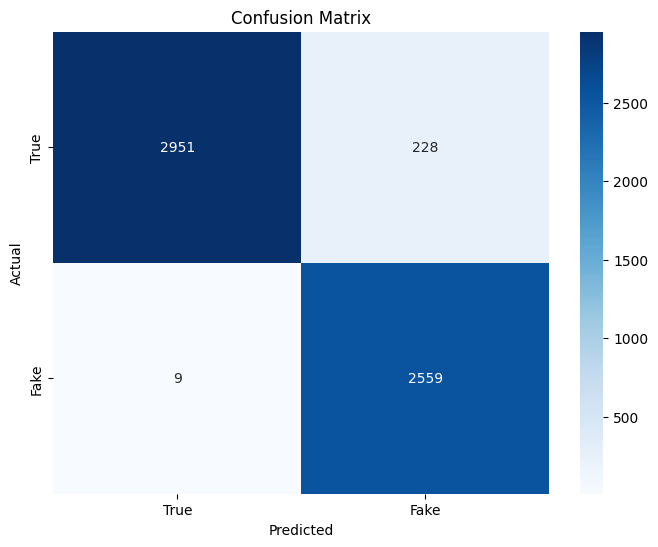

In [63]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["True", "Fake"],
    yticklabels=["True", "Fake"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
accuracy_test = accuracy_score(y_test, test_preds)
f1_test = f1_score(y_test, test_preds)

print(f"Accuracy on test set: {accuracy_test:.4f}")
print(f"F1 Score on test set: {f1_test:.4f}")

Accuracy on test set: 0.9588
F1 Score on test set: 0.9557


It looks like the model is performing really well on test set, with a very good recall. The features we have identified in our dataset are reflecting the main content of the articles, but they might struggle with a different set of news.

### ***11. Test on Synthetic Dataset***

We have generated a test dataset with the help of AI tools, the dates of the news are different from the dataset used to train the models, so we can verify the quality of its generalization.

In [5]:
synthetic_data = pd.read_csv('dataset/synthetic_news.csv')

We run it through data preprocessing and load the saved model after splitting relevant features from label.

In [6]:
synthetic_data_preprocessed = run_pipeline(synthetic_data, "text")

In [8]:
X_synth = synthetic_data_preprocessed[features]
y_synth = synthetic_data_preprocessed["fake"]

In [ ]:
with open("models/heuristic_model.pkl", "rb") as f:
    data = pickle.load(f)
    model = HeuristicFakeNewsModel(threshold=data["threshold"])
    model.rules = data["rules"]

It is time for predicting the labels of synthetic news.

In [12]:
synth_preds = model.predict(X_synth)
cm_synth = confusion_matrix(y_synth, synth_preds)

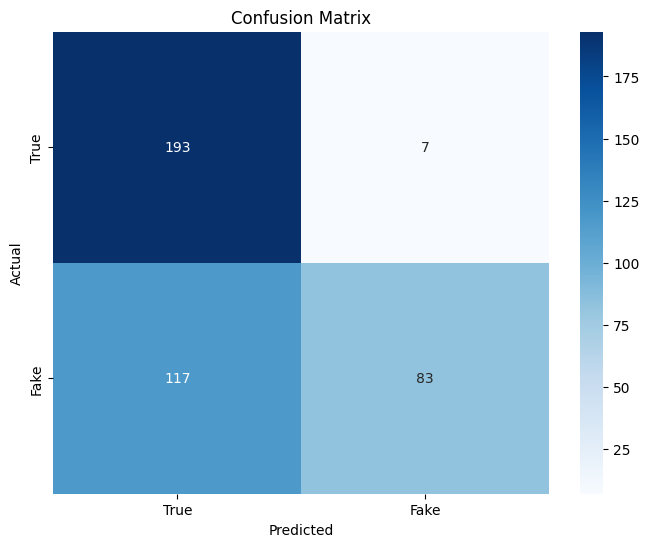

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_synth,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["True", "Fake"],
    yticklabels=["True", "Fake"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
report_dict = classification_report(y_synth, synth_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

print("Classification Report:")
display(report_df)

Classification Report:


,precision,recall,f1-score,support
0,0.623,0.965,0.757,200.00
1,0.922,0.415,0.572,200.00
accuracy,0.690,0.690,0.690,0.69
macro avg,0.772,0.690,0.665,400.00
weighted avg,0.772,0.690,0.665,400.00


Looking at these metrics, seems like the model excels at finding real news (96.5% recall) but often mislabels fake news as real (only 62.3% precision).
On the contrary when it flags something as fake, it's usually right (92.2% precision), but it misses most fake articles (41.5% recall).
Basically the model plays it safe, it only calls something `fake` when absolutely certain, letting many articles pass. This might be problematic if the goal is catching more fake content.